In [1]:
#core python libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

#ot library
import ot

#imort local files
from utils import simulate_dataset, format_dataset
from repairs import DI_list_geometric_repair, DI_list_random_repair, geometric_repair, DI_list_geometric_repair_data, DI_list_merge_repair_data, merger_repair
from disparate import *


#tools for data visualization
from sklearn.manifold import TSNE
#models for classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#tools for model evaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy.stats import entropy
from numpy.linalg import norm

In [2]:
#colours 
blue1 = '#1f77b4' # darker blue
blue2 = '#aec7e8' # lighter blue

# Two shades of red
red1 = '#d62728' # darker red
red2 = '#ff9896' # lighter red


In [3]:
def KLD(P, Q):
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    return entropy(_P, _Q)

In [4]:
# Read the data
df = pd.read_csv('compas_scores_two_years.csv')


df_race = df['race']
df_race.unique()


df_AA = df[df['race'] == 'African-American']
df_CC = df[df['race'] != 'African-American']

df_AA = df_AA.sample(n=1000)
df_CC = df_CC.sample(n=1000)

DI  = (len(df_AA[df_AA['decile_score'] ==1]))/len(df_CC[df_CC['decile_score'] ==1])
print(DI)

0.3322784810126582


In [5]:
#create Df with only these columns
df_new1 = df.drop(columns=['id','name','first','last','compas_screening_date','dob', 
'days_b_screening_arrest','c_jail_in','c_jail_out','c_case_number','c_offense_date','c_arrest_date','c_days_from_compas','c_charge_desc',
'r_case_number','r_charge_degree','r_days_from_arrest','r_offense_date','r_charge_desc','r_jail_in','r_jail_out','violent_recid','is_violent_recid','vr_case_number',
'vr_charge_degree','vr_offense_date','vr_charge_desc','type_of_assessment','decile_score','screening_date','v_type_of_assessment','v_decile_score', 'is_recid',
'v_screening_date','in_custody','out_custody','start','end','event'])
print(df_new1.columns)
df_new = df_new1.drop(columns=['age', 'priors_count.1', 'decile_score.1'])
print(df_new.columns)

df_new['sex']  = df_new['sex'].replace({'Male':1, 'Female':0})
df_new['age_cat'] = df_new['age_cat'].replace({'Greater than 45':3, '25 - 45':2, 'Less than 25':1})
df_new['c_charge_degree'] = df_new['c_charge_degree'].replace({'F':1, 'M':0})
df_new['score_text'] = df_new['score_text'].replace({'Low':1, 'Medium':2, 'High':3})
df_new['v_score_text']  = df_new['v_score_text'].replace({'Low':1, 'Medium':2, 'High':3})


Index(['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree', 'decile_score.1',
       'score_text', 'v_score_text', 'priors_count.1', 'two_year_recid'],
      dtype='object')
Index(['sex', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'c_charge_degree', 'score_text',
       'v_score_text', 'two_year_recid'],
      dtype='object')


In [6]:
import pandas as pd

# Create a crosstab between the two variables with flipped axes
matrix = pd.crosstab(df_new['two_year_recid'], df_new['age_cat'])

# Divide each cell by the total number of observations
matrix = matrix / len(df_new)

print(matrix)




age_cat                1         2         3
two_year_recid                              
0               0.092182  0.307735  0.149432
1               0.119767  0.261852  0.069032


In [7]:
#split with race 
X0 = df_new[df_new['race'] != 'African-American']
X1 = df_new[df_new['race'] == 'African-American']

#drop race column
X0  = X0.drop(['race'], axis=1)
X1  = X1.drop(['race'], axis=1)

Y0 = X0['two_year_recid']
X0 = X0.drop(['two_year_recid'], axis=1)

Y1 = X1['two_year_recid']
X1 = X1.drop(['two_year_recid'], axis=1)

#split into train and test
X0_train, X0_test, Y0_train, Y0_test = train_test_split(X0, Y0, test_size=0.2, random_state=42)
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)

#train model
clf = LogisticRegression(random_state=0).fit(X0_train, Y0_train)
beta0 = []
intercept0 = clf.intercept_
for length in range(len(clf.coef_[0])):
    beta0.append(clf.coef_[0][length])


clf1 = LogisticRegression(random_state=0).fit(X1_train, Y1_train)
beta1 = []
intercept1 = clf1.intercept_
for length in range(len(clf1.coef_[0])):
    beta1.append(clf1.coef_[0][length])



#predict
Y0_pred = clf.predict(X0_test)
Y1_pred = clf1.predict(X1_test)

#accuracy
print("Accuracy of African-American group: ", metrics.accuracy_score(Y0_test, Y0_pred))
print("Accuracy of non African-American group : ", metrics.accuracy_score(Y1_test, Y1_pred))



print ('intercept1', intercept1)  

print ('beta1')
print (beta1)

#



Accuracy of African-American group:  0.7017045454545454
Accuracy of non African-American group :  0.6608108108108108
intercept1 [-0.56236344]
beta1
[0.4428796496944277, -0.5971127243994281, 0.0824377764431129, -0.06082225271723168, 0.2356643234494562, 0.1064679549138931, 0.09233684909914124, 0.34551848367127797, 0.1520384477673508]


In [8]:
X,Y = format_dataset(X0_test, X1_test, Y0 , Y1) 

In [9]:

X0_test = X0_test.to_numpy()
X1_test = X1_test.to_numpy()


In [11]:
iter = 100
DI_geometric, X0r, X1r, y0r, y1r, =DI_list_geometric_repair_data(X0_test,X1_test, beta0,beta1, intercept0, intercept1, iter)
DI_geometric= np.array(DI_geometric)

(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(1444, 10)
(1444,)
(1444,)
(

<Figure size 1000x800 with 0 Axes>

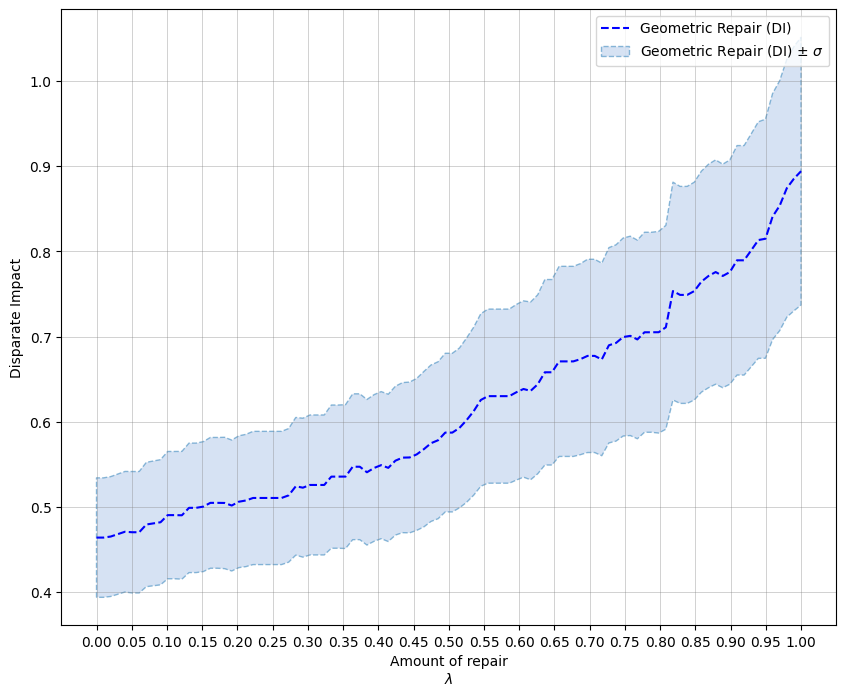

In [ ]:
#---format the repaired dataset
fig = plt.figure(figsize=(10, 8))


alpha = np.linspace(0,1,iter)


fig = plt.figure(figsize=(10, 8))
plt.plot(alpha,DI_geometric[:,1], label = 'Geometric Repair (DI)', color = 'blue', linestyle = 'dashed')
plt.fill_between(alpha, DI_geometric[:,2], DI_geometric[:,0], alpha=0.5, edgecolor=blue1, facecolor=blue2, linewidth=1, antialiased=True, linestyle = 'dashed', label=r'Geometric Repair (DI) ± $\sigma$')


plt.xlabel('Amount of repair\n'+r'$\lambda$')
plt.ylabel('Disparate Impact')
plt.legend()
# generate a sequence of 5 evenly spaced numbers between 0 and 4
grid_pos = np.arange(0, 1.05, 0.05)

# draw vertical grid lines at the specified positions
plt.grid(axis='both', color='grey', linewidth=.5, linestyle='-', which='major', alpha=0.5)
plt.gca().set_xticks(grid_pos, minor=False)
plt.show()

In [ ]:
def sigmoid(x):
    x = np.clip(x, -50, 50)
    return 1 / (1 + np.exp(-x))

In [ ]:
def merge_1(mu, mu2, cov , cov2, weights):


    alpha = (weights[0])**2/(weights[0]+weights[1])**2
    #alpha = (weights[0])/(weights[0]+weights[1])

    mu_m = (weights[0]*mu + weights[1]*mu2)/(weights[0]+weights[1])
    #cov_m = (weights[0]*cov + weights[1]*cov2 + weights[0]*weights[1]/(weights[0]+weights[1])*(mu-mu2).dot((mu-mu2).T))/(weights[0]+weights[1])
    cov_m  = alpha*cov + (1-alpha)*cov2
    weight_m = weights[0]+weights[1]

    return mu_m, cov_m, weight_m


In [ ]:
def merger_repair(X0,X1, alpha): 

    #find the mean and covariance of the two datasets
    mu = np.mean(X0, axis=0)
    cov = np.cov(X0.T)
    mu2 = np.mean(X1, axis=0)
    cov2 = np.cov(X1.T)

    #find the weights of the two datasets
    weights = np.array([X0.shape[0], X1.shape[0]])
    weights = weights/np.sum(weights)

    mu_m, cov_m, weights_m  = merge_1(mu, mu2, cov , cov2, weights)

    A_m = np.linalg.cholesky(cov_m)
    d = np.shape(mu_m)[0]


    X0r = np.zeros((len(X0),d)) 
    for i in range (len(X0)):

            r = np.random.rand()
            if r < alpha:
                #step 1: zero the mean
                x = X0[i,:] - mu
                #step 2: rotate the data
                x = np.dot(A_m, x)
                #step 3: scale the data
                x = mu_m + x
                X0r[i,:] = x
            else:
                X0r[i,:] = X0[i,:]
            
    X1r = np.zeros((len(X1),d))

    for i in range (len(X1)):
            
            r = np.random.rand()
            if r < alpha:
                    #step 1: zero the mean
                    x = X1[i,:] - mu2
                    #step 2: rotate the data
                    x = np.dot(A_m, x)
                    #step 3: scale the data
                    x = mu_m + x
                    X1r[i,:] = x
            else:
                    X1r[i,:] = X1[i,:]

    return X0r, X1r

In [ ]:
def DI_list_merge_repair_data_1(X0, X1, beta0, beta1, intercept0, intercept1,iter):
    DIs = []
    alphas = np.linspace(0,1,iter)
    for alpha in alphas:
        X0r, X1r = merger_repair(X0, X1, alpha)
        # log odds of positive outcome
        y0 = sigmoid(X0r.dot(beta0) + intercept0)
        #hist yo
        # plt.hist(y0,bins = 100)
        # plt.show()
        # # log odds of positive outcome
        y1 = sigmoid(X1r.dot(beta1) + intercept1)
        # plt.hist(y1,bins = 100)
        # plt.show()

        X,Y = format_dataset(X0r, X1r, y0, y1)

    
        #covert Y to 0 and 1
        Y = np.where(Y > 0.5, 1, 0)

        #train logistic regression
        clf = LogisticRegression(random_state=69).fit(X[:, 1:], Y)
        Y_pred = clf.predict(X[:, 1:])


        DIs.append(disparate(X,Y_pred,0))
        

    return DIs

In [ ]:
#---format the repaired 
DI_merge=DI_list_merge_repair_data_1(X0_test,X1_test, beta0,beta1, intercept0, intercept1, iter)
DI_merge= np.array(DI_merge)


<Figure size 1000x800 with 0 Axes>

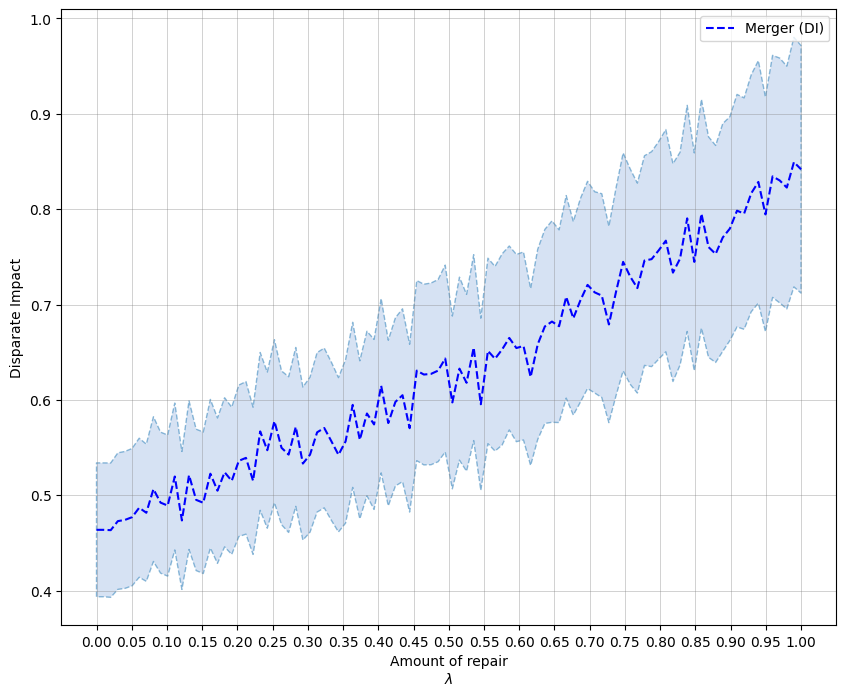

In [ ]:
#---format the repaired dataset

alpha = np.linspace(0,1,iter)


fig = plt.figure(figsize=(10, 8))
plt.plot(alpha,DI_merge[:,1], label = 'Merger (DI)', color = 'blue', linestyle = 'dashed')
plt.fill_between(alpha, DI_merge[:,2], DI_merge[:,0], alpha=0.5, edgecolor=blue1, facecolor=blue2, linewidth=1, antialiased=True, linestyle = 'dashed')


plt.xlabel('Amount of repair\n'+r'$\lambda$')
plt.ylabel('Disparate Impact')
plt.legend()
# generate a sequence of 5 evenly spaced numbers between 0 and 4
grid_pos = np.arange(0, 1.05, 0.05)

# draw vertical grid lines at the specified positions
plt.grid(axis='both', color='grey', linewidth=.5, linestyle='-', which='major', alpha=0.5)
plt.gca().set_xticks(grid_pos, minor=False)
plt.show()